# Prepare Dataset


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['deceptive-opinion-spam-corpus', 'glove-global-vectors-for-word-representation', 'googles-trained-word2vec-model-in-python', 'yelp-test', 'yelp-train']


In [2]:
from __future__ import print_function
from keras.preprocessing.text import text_to_word_sequence
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
from bs4 import BeautifulSoup
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, MaxPooling1D, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [3]:
data = pd.read_csv(
    "./input/deceptive-opinion-spam-corpus/deceptive-opinion-augmented.csv"
)

In [4]:
data.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stay for a one night getaway with family on...
1,truthful,conrad,positive,TripAdvisor,We stayed here for a one night family getaway ...
2,truthful,hyatt,positive,TripAdvisor,triple A rate with upgrade to view room was le...
3,truthful,hyatt,positive,TripAdvisor,The Triple A rate with a view room upgrade was...
4,truthful,hyatt,positive,TripAdvisor,This semen a little late as I'm finally catchi...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  3200 non-null   object
 1   hotel      3200 non-null   object
 2   polarity   3200 non-null   object
 3   source     3200 non-null   object
 4   text       3200 non-null   object
dtypes: object(5)
memory usage: 125.1+ KB


In [6]:
df = data[["deceptive", "polarity", "text"]]  # df[['C', 'D', 'E']]

In [7]:
df1 = df.sample(frac=1)

<Axes: xlabel='deceptive'>

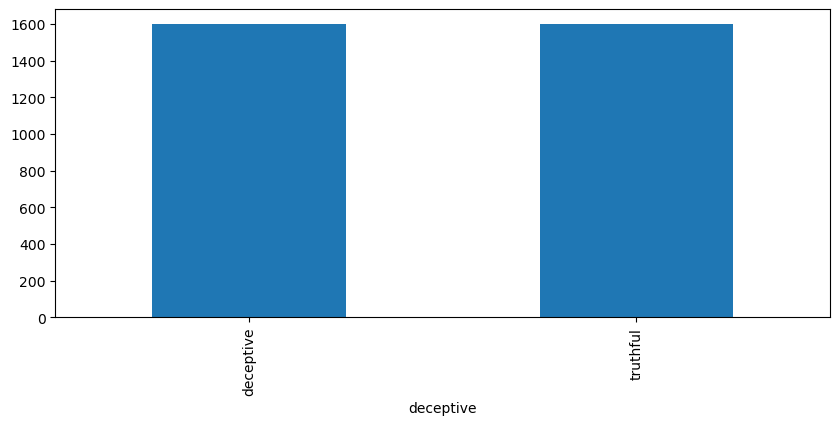

In [8]:
import matplotlib.pyplot as plt

my_tags = ["deceptive", "truthful"]
plt.figure(figsize=(10, 4))
df1.deceptive.value_counts().plot(kind="bar")

Text(0, 0.5, 'Polarity')

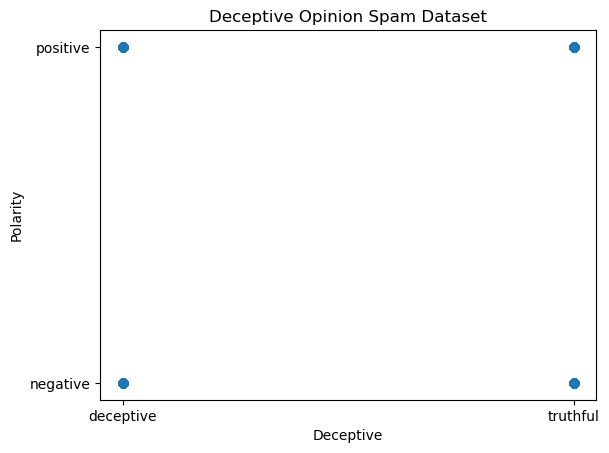

In [9]:
fig, ax = plt.subplots()

# scatter the sepal_length against the sepal_width
ax.scatter(df1["deceptive"], df1["polarity"])
# set a title and labels
ax.set_title("Deceptive Opinion Spam Dataset")
ax.set_xlabel("Deceptive")
ax.set_ylabel("Polarity")

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3200 entries, 3172 to 2758
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  3200 non-null   object
 1   polarity   3200 non-null   object
 2   text       3200 non-null   object
dtypes: object(3)
memory usage: 100.0+ KB


In [14]:
df1.head()

,deceptive,polarity,text
3172,deceptive,negative,The Hilton family would beryllium outraged aft...
448,truthful,positive,"iodine had a large, roomy, clean 2 bed room wi..."
1170,deceptive,positive,For angstrom short time during vacation I had ...
1855,truthful,negative,The elevator system was impossible. It seems l...
2839,deceptive,negative,What I had hoped would be a pleasant stay turn...


In [15]:
df2 = df1.drop(columns=["polarity"], axis=1)

In [16]:
df2.describe()

,deceptive,text
count,3200,3200
unique,2,3192
top,deceptive,"I was looking for a nice, non-chain hotel for ..."
freq,1600,2


In [17]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df2["deceptive"] = label_encoder.fit_transform(df2["deceptive"])

df2["deceptive"].unique()

array([0, 1])

In [18]:
df2.head()

,deceptive,text
3172,0,The Hilton family would beryllium outraged aft...
448,1,"iodine had a large, roomy, clean 2 bed room wi..."
1170,0,For angstrom short time during vacation I had ...
1855,1,The elevator system was impossible. It seems l...
2839,0,What I had hoped would be a pleasant stay turn...


In [19]:
df2.describe()

,deceptive
count,3200.000000
mean,0.500000
std,0.500078
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


# Data preprocessing


In [20]:
from nltk.corpus import stopwords

In [21]:
import re

In [22]:
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile("[^0-9a-z #+_]")
STOPWORDS = set(stopwords.words("english"))


def clean_text(text):
    """
    text: a string

    return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text  # HTML decoding
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


df2["text"] = df2["text"].apply(clean_text)

C:\Users\james\AppData\Local\Temp\ipykernel_12408\507430188.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text  # HTML decoding


In [23]:
X = df2.text
y = df2.deceptive

In [24]:
X = X.map(lambda a: clean_text(a))

In [25]:
def text_to_wordlist(text):
    # Remove Special Characters
    text = re.sub(r"[^a-z\d ]", " ", text)
    text = re.sub(r"\d+", "_num_", text)
    return text

In [26]:
X = X.map(lambda a: text_to_wordlist(a))

In [27]:
train, test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [28]:
tokenizer = Tokenizer(
    num_words=None,
    lower=True,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    split=" ",
    char_level=False,
)

In [29]:
tokenizer.fit_on_texts(X)

In [30]:
x_train = tokenizer.texts_to_sequences(train)

In [31]:
x_test = tokenizer.texts_to_sequences(test)

In [32]:
word_index = tokenizer.word_index

In [33]:
X = tokenizer.texts_to_sequences(X)

In [34]:
vocab_size = len(word_index)
print("Vocab size: {}".format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print("Max comment size: {}".format(max_len))

Vocab size: 10210
Longest comment size: 795
Average comment size: 149.5671875
Stdev of comment size: 87.54077541831488
Max comment size: 412


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
processed_post_x_train = pad_sequences(
    x_train, maxlen=max_len, padding="post", truncating="post"
)
processed_post_x_test = pad_sequences(
    x_test, maxlen=max_len, padding="post", truncating="post"
)

In [37]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [38]:
print("x_train shape:", processed_x_train.shape)
print("x_test shape:", processed_x_test.shape)

x_train shape: (2400, 412)
x_test shape: (800, 412)


In [39]:
import keras.backend
from keras.models import Sequential, load_model
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [40]:
import os

In [41]:
embeddings_index = {}
f = open(
    os.path.join(
        "./input/glove-global-vectors-for-word-representation", "glove.6B.100d.txt"
    )
)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [42]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [43]:
# Initate model
model = Sequential()


model.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)


# ,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(LSTM(60, return_sequences=True, name="lstm_layer1"))
# kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(LSTM(30, return_sequences=True, name="lstm_layer2"))
# ,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

model.add(
    Dense(64, activation="relu", kernel_regularizer=l2(0.17), bias_regularizer=l2(0.01))
)
model.add(Dropout(0.3))
model.add(
    Dense(
        32, activation="sigmoid", kernel_regularizer=l2(0.19), bias_regularizer=l2(0.01)
    )
)
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 412, 100)          1021100   
                                                                 
 lstm_layer1 (LSTM)          (None, 412, 60)           38640     
                                                                 
 lstm_layer2 (LSTM)          (None, 412, 30)           10920     
                                                                 
 conv1d (Conv1D)             (None, 412, 128)          11648     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 137, 128)         0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                         

In [44]:
# adam = keras.optimizers.Adam(lr=0.03, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [45]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [46]:
history = model.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1,
)

Epoch 1/15
75/75 [==============================] - 37s 454ms/step - loss: 13.9404 - accuracy: 0.5908 - val_loss: 7.2261 - val_accuracy: 0.7763
Epoch 2/15
75/75 [==============================] - 33s 436ms/step - loss: 4.2553 - accuracy: 0.7462 - val_loss: 2.3910 - val_accuracy: 0.8275
Epoch 3/15
75/75 [==============================] - 33s 446ms/step - loss: 1.5315 - accuracy: 0.7921 - val_loss: 1.1358 - val_accuracy: 0.7100
Epoch 4/15
75/75 [==============================] - 35s 466ms/step - loss: 0.7965 - accuracy: 0.8525 - val_loss: 0.6660 - val_accuracy: 0.8750
Epoch 5/15
75/75 [==============================] - 35s 462ms/step - loss: 0.6590 - accuracy: 0.8263 - val_loss: 0.6543 - val_accuracy: 0.8012
Epoch 6/15
75/75 [==============================] - 37s 489ms/step - loss: 0.5428 - accuracy: 0.8950 - val_loss: 0.5200 - val_accuracy: 0.9013
Epoch 7/15
75/75 [==============================] - 35s 467ms/step - loss: 0.4673 - accuracy: 0.9383 - val_loss: 0.5296 - val_accuracy: 0.895

In [47]:
model.evaluate(processed_x_test, y_test)

25/25 [==============================] - 4s 161ms/step - loss: 0.3687 - accuracy: 0.9413


[0.368701696395874, 0.9412500262260437]

In [53]:
model.save("augmented_CNN.hdf5")

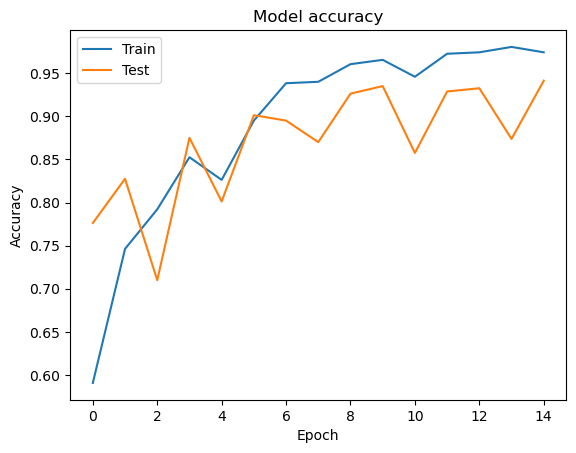

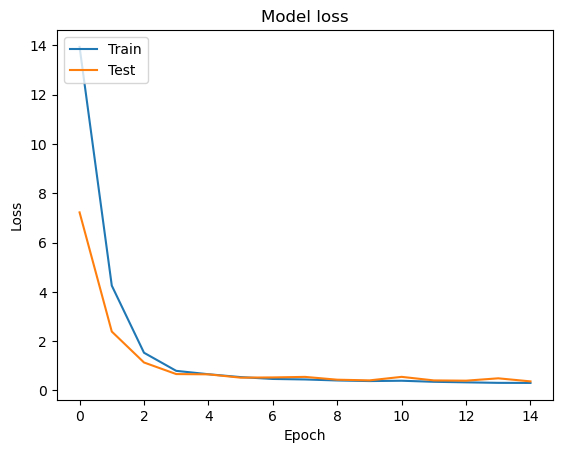

In [48]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

**CNN GLoVe **


In [49]:
model_glove = Sequential()
model_glove.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)
model_glove.add(Dropout(0.2))
model_glove.add(
    Conv1D(
        64, 5, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    )
)
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(BatchNormalization())
model_glove.add(LSTM(100, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model_glove.add(
    Dense(
        1, activation="sigmoid", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    )
)

model_glove.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 412, 100)          1021100   
                                                                 
 dropout_3 (Dropout)         (None, 412, 100)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 408, 64)           32064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 102, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 102, 64)          256       
 hNormalization)                                                 
                                                                 
 lstm (LSTM)                 (None, 100)              

In [50]:
model_glove.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [51]:
history = model_glove.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
)

Epoch 1/30
75/75 [==============================] - 10s 111ms/step - loss: 2.2527 - accuracy: 0.6425 - val_loss: 1.4605 - val_accuracy: 0.6375
Epoch 2/30
75/75 [==============================] - 7s 97ms/step - loss: 1.0520 - accuracy: 0.7975 - val_loss: 0.9451 - val_accuracy: 0.7812
Epoch 3/30
75/75 [==============================] - 7s 95ms/step - loss: 0.7456 - accuracy: 0.8671 - val_loss: 1.0838 - val_accuracy: 0.6200
Epoch 4/30
75/75 [==============================] - 7s 97ms/step - loss: 0.5555 - accuracy: 0.9108 - val_loss: 1.1821 - val_accuracy: 0.6137
Epoch 5/30
75/75 [==============================] - 7s 96ms/step - loss: 0.4594 - accuracy: 0.9400 - val_loss: 0.8560 - val_accuracy: 0.7150
Epoch 6/30
75/75 [==============================] - 7s 97ms/step - loss: 0.3929 - accuracy: 0.9554 - val_loss: 0.5383 - val_accuracy: 0.8838
Epoch 7/30
75/75 [==============================] - 7s 98ms/step - loss: 0.3622 - accuracy: 0.9575 - val_loss: 0.5303 - val_accuracy: 0.8737
Epoch 8/30


In [52]:
# Plot training & validation accuracy values
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

KeyError: 'acc'

2 LayreLSTM


In [ ]:
# Initate model
model_lstm = Sequential()


model_lstm.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)

input_shape = embedding_matrix[0].shape


# ,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model_lstm.add(LSTM(60, return_sequences=True, name="lstm_layer1"))
# kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model_lstm.add(LSTM(30, return_sequences=True, name="lstm_layer2"))
# model_lstm.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
# model_lstm.add(MaxPooling1D(3))
# model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(BatchNormalization())
model_lstm.add(Flatten())
model_lstm.add(
    Dense(64, activation="relu", kernel_regularizer=l2(0.17), bias_regularizer=l2(0.01))
)
model_lstm.add(Dropout(0.3))
model_lstm.add(
    Dense(
        32, activation="sigmoid", kernel_regularizer=l2(0.19), bias_regularizer=l2(0.01)
    )
)
model_lstm.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dense(20, activation="relu", input_shape=input_shape))
# model.add(Dense(20, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation="sigmoid"))
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 416, 100)          934100    
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 416, 60)           38640     
_________________________________________________________________
lstm_layer2 (LSTM)           (None, 416, 30)           10920     
_________________________________________________________________
batch_normalization_3 (Batch (None, 416, 30)           120       
_________________________________________________________________
flatten_1 (Flatten)          (None, 12480)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                798784    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
__________

In [ ]:
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
hist = model_lstm.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1,
)

Train on 1200 samples, validate on 400 samples
Epoch 1/15
1200/1200 [==============================] - 29s 24ms/step - loss: 11.9936 - acc: 0.4950 - val_loss: 6.1268 - val_acc: 0.5325
Epoch 2/15
1200/1200 [==============================] - 25s 20ms/step - loss: 4.9547 - acc: 0.6150 - val_loss: 3.9150 - val_acc: 0.6300
Epoch 3/15
1200/1200 [==============================] - 25s 21ms/step - loss: 3.1504 - acc: 0.7433 - val_loss: 2.5269 - val_acc: 0.7000
Epoch 4/15
1200/1200 [==============================] - 25s 21ms/step - loss: 2.0219 - acc: 0.8133 - val_loss: 2.0638 - val_acc: 0.6350
Epoch 5/15
1200/1200 [==============================] - 25s 21ms/step - loss: 1.2884 - acc: 0.8642 - val_loss: 1.2858 - val_acc: 0.6750
Epoch 6/15
1200/1200 [==============================] - 26s 21ms/step - loss: 0.8754 - acc: 0.9067 - val_loss: 0.8732 - val_acc: 0.8250
Epoch 7/15
1200/1200 [==============================] - 26s 22ms/step - loss: 0.5784 - acc: 0.9333 - val_loss: 0.6989 - val_acc: 0.8225


In [ ]:
# Plot training & validation accuracy values
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()